In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

In [2]:
from sklearn.datasets import make_circles
X,target = make_circles(n_samples=1024, shuffle=True, noise=.09, factor=.3)

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=1024, noise=.09)

display(X.shape, target.shape)

(1024, 2)

(1024,)

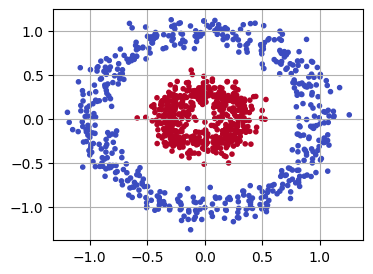

In [3]:
fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [4]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( x_train.shape, x_test.shape, )

assert len(target_train) == len(x_train)
assert len(target_test) == len(x_test)

del X,target

(512, 2)

(512, 2)

In [6]:
# y_train = np.eye(2)[target_train]
# y_test  = np.eye(2)[target_test]

# display(y_train.shape, y_test.shape)

In [7]:
# y_train

-----

In [8]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [9]:
class MyDataset(Dataset):
    
    def __init__(self, x,target ):
        super().__init__()
        assert len(x)==len(target)
        self._x = torch.tensor(x,dtype=torch.float32)
        self._target = torch.tensor(target,dtype=torch.long)
        self._classes = sorted(set(target))
    
    # размер датасета
    def __len__(self): 
        return len(self._target)
    
    def __getitem__(self, idx): 
        return (
            self._x[idx],
            # self._target[idx] 
            self._num2vec( self._target[idx]) 
        )
    
    def _num2vec(self,t): # заменяем номер слова на вектор [0,1] длинны в размер словаря
        return F.one_hot( t, num_classes=len(self._classes)).to( torch.float32 ) 

    

In [10]:
ds_train = MyDataset(x_train,target_train)

In [11]:
# len(ds_train)
# ds_train[:2]

In [12]:
# from torch.utils.data import DataLoader

In [13]:
# for x,t in DataLoader(ds_train,batch_size=16,shuffle=True): break

In [14]:
# x.shape, t.shape

----

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class MLP_3(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self._linear0 = nn.Linear( in_size, hidden_size[0] )
        self._linear1 = nn.Linear( hidden_size[0], hidden_size[1] )
        self._linear2 = nn.Linear( hidden_size[1], out_size )

        
    def forward(self,x):
        o = self._linear0(x)
        o = F.tanh(o)
        o = self._linear1(o)
        o = F.sigmoid(o)
        o = self._linear2(o)
        o = F.log_softmax(o,dim=-1)
        return o
    
    def predict(self,x):
        return torch.argmax( self.forward(x), dim=-1 ) #, keepdims=True)
    

In [17]:
model = MLP_3(
        in_size=x_train.shape[1],
        hidden_size=[16,8],
        out_size=len(set(target_train))
    )

In [18]:
# x,t = ds_train[:8]
# model(x)

----

In [19]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

# device = 'cpu'

device(type='cuda', index=0)

'Tesla P40'

In [20]:
model = model.to(device)

In [21]:
# ф-ция потери
# criterion =  nn.BCELoss()
criterion =  nn.MSELoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

----

In [22]:
from torch.utils.data import DataLoader

In [23]:
loss_history = [] # значения ф-ции потери

In [24]:
from tqdm.auto import tqdm

In [25]:
%%time

n_epoch = 1024 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds_train, batch_size=len(x_train)//5, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

  0%|          | 0/1024 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 160 ms, total: 13.6 s
Wall time: 13.9 s


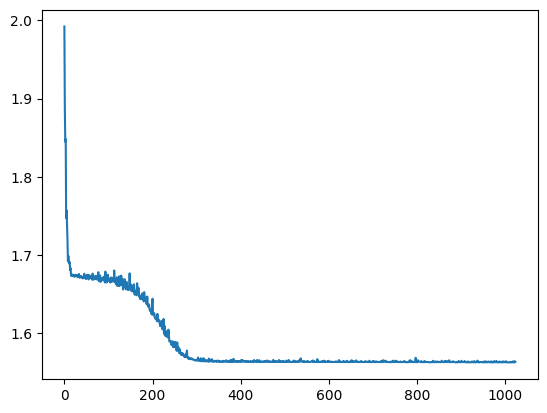

In [26]:
plt.plot(loss_history)

In [27]:
# # история изменения значений погрешности модели
# fig,ax = plt.subplots(ncols=2,figsize=(11,4))
# ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
# ax[0].grid()
# ax[0].set_title('accuracy')
# ax[0].legend()
# ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
# ax[1].grid()
# ax[1].set_title('loss')
# ax[1].legend()

In [28]:
ds_test = MyDataset(x_test,target_test)

In [29]:
from sklearn.metrics import classification_report

for x,t in DataLoader(ds_test,shuffle=False,batch_size=len(ds_test)):
    with torch.set_grad_enabled(False):
        predicted = model.predict(x.to(device)).cpu().numpy()

print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       244

    accuracy                           1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512



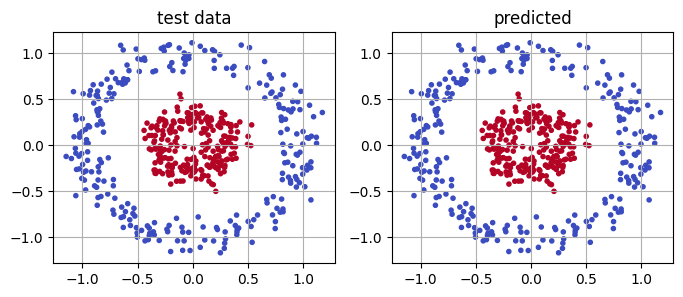

In [30]:
fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=x_test[:,0],y=x_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=x_test[:,0],y=x_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()